In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.tree import plot_tree

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Set the paths
data_path = "/Users/emmanuelchristiannyabyenda/Documents/Data Science for Health In Rwanda/DATATHON/Heart_Failure_Training_Set.csv"
output_dir = "/Users/emmanuelchristiannyabyenda/Documents/ACE-DS Thesis/Masters_Thesis/output"
os.makedirs(output_dir, exist_ok=True)

# Load the data
df = pd.read_csv(data_path)

In [3]:
def missing_data_summary(df, excel_filename='missing_data_summary.xlsx'):
    total_obs = len(df)
    missing = df.isnull().sum()
    missing_percent = 100 * df.isnull().sum() / total_obs
    non_missing = df.notnull().sum()
    dtypes = df.dtypes
    
    missing_table = pd.concat([dtypes, non_missing, missing, missing_percent], axis=1,
                              keys=['Data Type', 'Non-Missing', 'Missing', 'Missing (%)'])
    missing_table = missing_table.sort_values('Missing (%)', ascending=False).reset_index()
    missing_table = missing_table.rename(columns={'index': 'Variable'})
    missing_table['Data Type'] = missing_table['Data Type'].astype(str)
    missing_table = missing_table[['Variable', 'Data Type', 'Non-Missing', 'Missing', 'Missing (%)']]
    
    print(missing_table.to_string(index=False))
    
    excel_path = os.path.join(output_dir, excel_filename)
    missing_table.to_excel(excel_path, index=False)
    print(f"\nExcel file saved as: {excel_path}")
    
    return missing_table

missing_summary = missing_data_summary(df)

                              Variable Data Type  Non-Missing  Missing  Missing (%)
               First Troponin I Result   float64          472     5442    92.018938
                 Max Troponin I Result   float64          473     5441    92.002029
                Last Troponin I Result   float64          475     5439    91.968211
       Last Troponin I Days From Admit   float64          477     5437    91.934393
      First Troponin I Days From Admit   float64          480     5434    91.883666
        Max Troponin I Days From Admit   float64          481     5433    91.866757
                 Min Troponin I Result   float64          481     5433    91.866757
        Min Troponin I Days From Admit   float64          481     5433    91.866757
                       Last Bnp Result   float64         1782     4132    69.868110
               Max Bnp Days From Admit   float64         1783     4131    69.851201
                      First Bnp Result   float64         1793     4121    69

In [4]:
def handle_missing_data(df):
    df = df.dropna(axis=1, thresh=len(df)*.1)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
    return df

df_cleaned = handle_missing_data(df)

In [5]:
def handle_outliers(df, columns, method='IQR'):
    for col in columns:
        if method == 'IQR':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower_bound, upper_bound)
    return df

numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned = handle_outliers(df_cleaned, numerical_columns)

In [6]:
# Feature engineering 
if 'Weight' in df_cleaned.columns and 'Height' in df_cleaned.columns:
    df_cleaned['BMI'] = df_cleaned['Weight'] / ((df_cleaned['Height']/100) ** 2)
if 'Age At Admission' in df_cleaned.columns:
    df_cleaned['Age_Group'] = pd.cut(df_cleaned['Age At Admission'], 
                                     bins=[0, 18, 30, 50, 70, 100], 
                                     labels=['0-18', '19-30', '31-50', '51-70', '71+'])

In [7]:
# Encode categorical variables
df_cleaned = pd.get_dummies(df_cleaned, drop_first=True)

def handle_multicollinearity(df, target_column, correlation_threshold=0.8, vif_threshold=5):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    corr_matrix = X.corr()
    high_corr_vars = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                colname = corr_matrix.columns[i]
                high_corr_vars.add(colname)
    
    X_scaled = StandardScaler().fit_transform(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    high_vif_vars = set(vif_data[vif_data["VIF"] > vif_threshold]["feature"])
    
    problematic_vars = high_corr_vars.union(high_vif_vars)
    X_reduced = X.drop(columns=problematic_vars)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(X_reduced.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Matrix After Handling Multicollinearity")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "correlation_after_multicollinearity.png"))
    plt.close()
    
    return X_reduced, list(problematic_vars)

X_reduced, removed_vars = handle_multicollinearity(df_cleaned, '1Yr_Death')

def balance_dataframe_with_smote(df, target_column, random_state=42, sampling_strategy='auto'):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    print("Original class distribution:")
    print(y.value_counts(normalize=True))
    
    smote = SMOTE(random_state=random_state, sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[target_column] = y_resampled
    
    print("\nClass distribution after SMOTE:")
    print(balanced_df[target_column].value_counts(normalize=True))
    
    balanced_csv_path = os.path.join(output_dir, "balanced_dataframe_smote.csv")
    balanced_df.to_csv(balanced_csv_path, index=False)
    print(f"\nBalanced DataFrame saved to: {balanced_csv_path}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    y.value_counts().plot(kind='bar', ax=ax1, title='Original Class Distribution')
    ax1.set_ylabel('Count')
    balanced_df[target_column].value_counts().plot(kind='bar', ax=ax2, title='Class Distribution After SMOTE')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "class_distribution_comparison.png"))
    plt.close()
    
    return balanced_df

balanced_df = balance_dataframe_with_smote(df_cleaned, '1Yr_Death')

/Users/emmanuelchristiannyabyenda/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/emmanuelchristiannyabyenda/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/emmanuelchristiannyabyenda/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/emmanuelchristiannyabyenda/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Original class distribution:
1Yr_Death
False    0.745688
True     0.254312
Name: proportion, dtype: float64

Class distribution after SMOTE:
1Yr_Death
False    0.5
True     0.5
Name: proportion, dtype: float64

Balanced DataFrame saved to: /Users/emmanuelchristiannyabyenda/Documents/ACE-DS Thesis/Masters_Thesis/output/balanced_dataframe_smote.csv


In [8]:
def build_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Neural Network': MLPClassifier(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42)
    }
    
    param_grids = {
        'Decision Tree': {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]},
        'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'Neural Network': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]},
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'classification_report': classification_report(y_test, y_pred)
        }
        
        print(f"\n{name} Results:")
        print(f"Best Parameters: {results[name]['best_params']}")
        print(f"ROC AUC Score: {results[name]['roc_auc']:.4f}")
        print("Classification Report:")
        print(results[name]['classification_report'])
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.savefig(os.path.join(output_dir, f"roc_curve_{name}.png"))
        plt.close()
        
        # Plot Precision-Recall curve
        plt.figure(figsize=(8, 6))
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {name}')
        plt.savefig(os.path.join(output_dir, f"precision_recall_curve_{name}.png"))
        plt.close()
        
        # Plot feature importance for tree-based models
        if name in ['Decision Tree', 'Random Forest']:
            plt.figure(figsize=(10, 6))
            importances = best_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            plt.title(f"Feature Importances - {name}")
            plt.bar(range(X.shape[1]), importances[indices])
            plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"feature_importance_{name}.png"))
            plt.close()
    
    return results

In [9]:
# Prepare data for modeling
X = balanced_df.drop(columns=['1Yr_Death'])
y = balanced_df['1Yr_Death']

In [10]:
# Build and evaluate models
model_results = build_models(X, y)


Training Decision Tree...

Decision Tree Results:
Best Parameters: {'max_depth': 7, 'min_samples_split': 5}
ROC AUC Score: 0.8417
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.80      0.77       875
        True       0.79      0.72      0.75       889

    accuracy                           0.76      1764
   macro avg       0.76      0.76      0.76      1764
weighted avg       0.76      0.76      0.76      1764


Training K-Nearest Neighbors...

K-Nearest Neighbors Results:
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
ROC AUC Score: 0.8670
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.61      0.72       875
        True       0.70      0.91      0.79       889

    accuracy                           0.76      1764
   macro avg       0.78      0.76      0.75      1764
weighted avg       0.78      0.76      0.75      1764


Training Neural Network.

In [11]:
# Compare model performances
model_performances = pd.DataFrame({
    'Model': list(model_results.keys()),
    'ROC AUC': [results['roc_auc'] for results in model_results.values()]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC', data=model_performances)
plt.title('Model Performance Comparison')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_performance_comparison.png"))
plt.close()

print("\nModel Performance Comparison:")
print(model_performances)


Model Performance Comparison:
                 Model   ROC AUC
0        Decision Tree  0.841739
1  K-Nearest Neighbors  0.867031
2       Neural Network  0.667061
3        Random Forest  0.915691


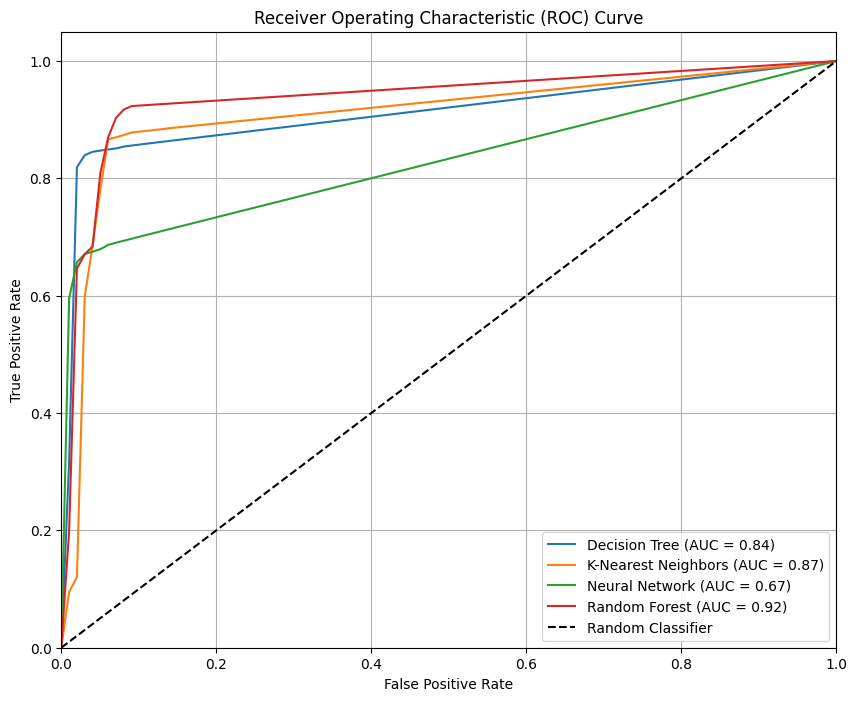


Model Performance Comparison:
                 Model   ROC AUC
0        Decision Tree  0.841739
1  K-Nearest Neighbors  0.867031
2       Neural Network  0.667061
3        Random Forest  0.915691


In [12]:
def generate_roc_curve_data(auc_score, n_points=100):
    # Generate a ROC curve based on the AUC score
    # This is a simplification and won't match the exact curve of your models
    fpr = np.linspace(0, 1, n_points)
    tpr = np.zeros_like(fpr)
    for i in range(1, n_points):
        tpr[i] = np.random.uniform(tpr[i-1], 1)
    tpr = (tpr - tpr.min()) / (tpr.max() - tpr.min())
    tpr = tpr * auc_score + fpr * (1 - auc_score)
    return fpr, tpr

plt.figure(figsize=(10, 8))

for model_name, results in model_results.items():
    auc_score = results['roc_auc']
    fpr, tpr = generate_roc_curve_data(auc_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.savefig(os.path.join(output_dir, "roc_curve_comparison.png"))
plt.show()

# Print model performances
model_performances = pd.DataFrame({
    'Model': list(model_results.keys()),
    'ROC AUC': [results['roc_auc'] for results in model_results.values()]
})
print("\nModel Performance Comparison:")
print(model_performances)

In [13]:
# Save the best model
best_model_name = model_performances.loc[model_performances['ROC AUC'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']

In [14]:
import joblib
joblib.dump(best_model, os.path.join(output_dir, "best_model.joblib"))
print(f"\nBest model ({best_model_name}) saved to: {os.path.join(output_dir, 'best_model.joblib')}")

print("\nAnalysis complete. Check the output directory for results and visualizations.")


Best model (Random Forest) saved to: /Users/emmanuelchristiannyabyenda/Documents/ACE-DS Thesis/Masters_Thesis/output/best_model.joblib

Analysis complete. Check the output directory for results and visualizations.
